# Creating the Neural Network Using Base and Top Model

In [1]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense

# path to the model weights file.
weights_path = './VGG/vgg16_weights.h5'
top_model_weights_path = './VGG/bottleneck_fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = './Pictures/Train'
validation_data_dir = './Pictures/Validation'
nb_train_samples = 13675
nb_validation_samples = 3435
nb_epoch = 10


Using TensorFlow backend.


In [ ]:
#Locate the files that do not open properly

# import PIL
# from glob import glob

# for filename in glob(validation_data_dir + "/*/*.png"):
#     try:
#         _ = PIL.Image.open(filename)
#         _.load()
#     except IOError:
#         print(filename)

In [ ]:
#Remove files that do not open properly

# from glob import glob
# import os

# for filename in glob(train_data_dir + "/*/.DS_Store"):
#     try:
#         print str(filename)
# #         os.remove(filename)
#     except IOError:
#         pass

# Base Model

In [2]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

# build the VGG16 network
base_model = Sequential()
base_model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

base_model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
base_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
base_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
base_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
base_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
base_model.add(ZeroPadding2D((1, 1)))
base_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
base_model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# load the weights of the VGG16 networks
# (trained on ImageNet, won the ILSVRC competition in 2014)
# note: when there is a complete match between your model definition
# and your weight savefile, you can simply call model.load_weights(filename)
assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(base_model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    base_model.layers[k].set_weights(weights)
base_model.save('./VGG/base_model.h5')
f.close()
print('Model loaded.')

Model loaded.


In [ ]:
#generator for training data

# generator = datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_width, img_height),
#         batch_size=32,
#         class_mode=None,
#         shuffle=False)
# bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
# np.save(open('./VGG/bottleneck_features_train.npy', 'w'), bottleneck_features_train)

In [ ]:
#generator for test data

# generator = datagen.flow_from_directory(
#          validation_data_dir,
#          target_size=(img_width, img_height),
#          batch_size=32,
#          class_mode=None,
#          shuffle=False)
# bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
# np.save(open('./VGG/bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)


# Top Model

In [4]:
#loading in train and test labels

import pickle
with open('puppy_labels.pkl','rb') as f:
    train_labels, test_labels = pickle.load(f)

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

In [6]:
encoded_train_labels = LabelEncoder().fit_transform(train_labels)
encoded_train_labels = to_categorical(encoded_train_labels,30)

encoded_test_labels = LabelEncoder().fit_transform(test_labels)
encoded_test_labels = to_categorical(encoded_test_labels,30)

In [7]:
encoded_train_labels.shape
encoded_test_labels.shape

(3435, 30)

In [8]:
train_data = np.load(open('./VGG/bottleneck_features_train.npy'))
train_labels = np.array(encoded_train_labels)

validation_data = np.load(open('./VGG/bottleneck_features_validation.npy'))
validation_labels = np.array(encoded_test_labels)

top_model = Sequential()
top_model.add(Flatten(input_shape=train_data.shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(30, activation='softmax'))

top_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

top_model.fit(train_data, train_labels,
      nb_epoch=nb_epoch, batch_size=32,
      validation_data=(validation_data, validation_labels))
top_model.save_weights(top_model_weights_path)

#make sure to save the model itself in addition to the weights

Train on 13675 samples, validate on 3435 samples
Epoch 1/10
13675/13675 [==============================] - 3s - loss: 3.0587 - acc: 0.1361 - val_loss: 2.3547 - val_acc: 0.3144
Epoch 2/10
13675/13675 [==============================] - 3s - loss: 2.4908 - acc: 0.2550 - val_loss: 2.0508 - val_acc: 0.3869
Epoch 3/10
13675/13675 [==============================] - 3s - loss: 2.3107 - acc: 0.3038 - val_loss: 1.8855 - val_acc: 0.4638
Epoch 4/10
13675/13675 [==============================] - 3s - loss: 2.1669 - acc: 0.3440 - val_loss: 1.8222 - val_acc: 0.4780
Epoch 5/10
13675/13675 [==============================] - 3s - loss: 2.0631 - acc: 0.3755 - val_loss: 1.7097 - val_acc: 0.5031
Epoch 6/10
13675/13675 [==============================] - 3s - loss: 1.9831 - acc: 0.3994 - val_loss: 1.8449 - val_acc: 0.4524
Epoch 7/10
13675/13675 [==============================] - 3s - loss: 1.9243 - acc: 0.4192 - val_loss: 1.7282 - val_acc: 0.4984
Epoch 8/10
13675/13675 [==============================] - 3s -

# Confusion Matrix

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

/home/icarus/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [11]:
y_pred = top_model.predict(validation_data)

In [12]:
y_test_confus = []
y_pred_confus = []
for elem in encoded_test_labels:
    y_test_confus.append(list(elem).index(max(elem)))
for item in y_pred:
    y_pred_confus.append(list(item).index(max(item)))
    

In [13]:
confus_mat = confusion_matrix(y_test_confus, y_pred_confus)

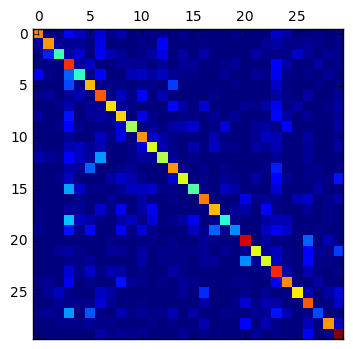

In [14]:
plt.matshow(confus_mat)

# Obtaining Vectors for Test Set

In [2]:
base_model = load_model('./VGG/base_model.h5')
top_model = load_model('./VGG/top_model.h5')

(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{add,no_inplace}.0, Elemwise{add,no_inplace}.0, Subtensor{int64}.0)
(Subtensor{int64}.0, Elemwise{

/Users/Sam/anaconda2/lib/python2.7/site-packages/keras/models.py:136: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
import cv2

In [4]:
img = cv2.resize(cv2.imread('Validation/Chihuahua/10.png'), (150, 150)).astype(np.float32)

img[:,:,0] -= 103.939
img[:,:,1] -= 116.779
img[:,:,2] -= 123.68
img = img.transpose((2,0,1))
img = np.expand_dims(img, axis=0)

error: /tmp/opencv-20161020-7399-1yrk4nm/opencv-2.4.13.1/modules/imgproc/src/imgwarp.cpp:1968: error: (-215) ssize.area() > 0 in function resize


In [12]:
bottleneck_features_test = base_model.predict(img)

In [14]:
train_data = np.load(open('./VGG/bottleneck_features_train.npy'))
test_model = Sequential()
test_model.add(Flatten(input_shape=train_data.shape[1:]))
test_model.add(Dense(256, activation='relu', weights=top_model.layers[1].get_weights()))

In [15]:
activation_vectors = test_model.predict(bottleneck_features_test)

In [16]:
activation_vectors.shape

(1, 256)